In [4]:
%pip install pandas numpy statsmodels arch matplotlib yfinance

  Using cached yfinance-0.2.41-py2.py3-none-any.whl.metadata (11 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached lxml-5.2.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata (3.4 kB)
  Using cached frozendict-2.4.4-cp310-cp310-macosx_10_15_x86_64.whl
  Using cached peewee-3.17.6-cp310-cp310-macosx_10_15_x86_64.whl
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
  Using cached soupsieve-2.5-py3-none-any.whl.metadata (4.7 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
Using cached yfinance-0.2.41-py2.py3-none-any.whl (73 kB)
Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
Using cached lxml-5.2.2-cp310-cp310-macosx_10_9_x86_64.whl (4.4 MB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
Using cached soupsieve-2.5-py3-none-any.whl (36 kB)
Using cached webenco

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

In [25]:
ticker = 'BN' # Example ticker
data = yf.download(ticker, start='2022-01-01', end='2024-01-01')
data['Returns'] = data['Adj Close'].pct_change()
data = data.dropna()

# split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data['Returns'][:train_size], data['Returns'][train_size:]

# ARIMA model
arima_order = (5, 0, 5) # (lag observations, difference order, MA window size)
arima_model = ARIMA(train, order=arima_order)
arima_fit = arima_model.fit()

# predict returns and conf int using ARIMA
arima_forecast = arima_fit.forecast(steps=len(test))
arima_conf_int = arima_fit.get_forecast(steps=len(test)).conf_int()

# GARCH model
garch_model = arch_model(train, vol='Garch', p=1, q=1) # p: AR lag, q: MA lag
garch_fit = garch_model.fit(disp='off')

# predict volatility using GARCH
garch_forecast = garch_fit.forecast(horizon=len(test))
garch_returns = garch_forecast.mean.values[-1, :]
garch_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

# calculate 95% conf int
conf_interval_upper = arima_forecast + 1.96 * garch_volatility
conf_interval_lower = arima_forecast - 1.96 * garch_volatility

[*********************100%%**********************]  1 of 1 completed


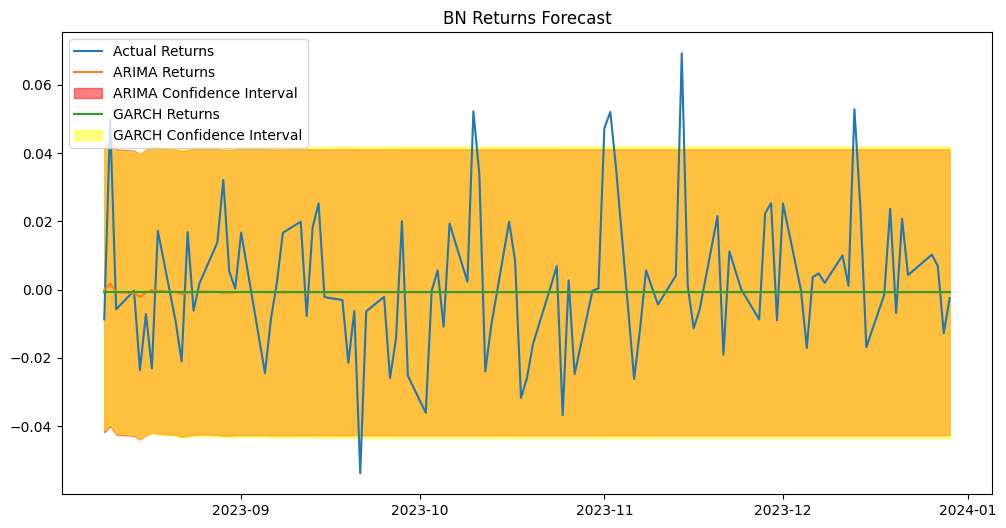

In [28]:
# plot GARCH and ARIMA returns and confidence interval
plt.figure(figsize=(12, 6))

plt.plot(test.index, test, label='Actual Returns')
plt.plot(test.index, arima_forecast, label='ARIMA Returns')
plt.fill_between(test.index, arima_conf_int["lower Returns"], arima_conf_int["upper Returns"], color='red', alpha=0.5, label='ARIMA Confidence Interval')

plt.plot(test.index, garch_returns, label='GARCH Returns')
plt.fill_between(test.index, conf_interval_lower, conf_interval_upper, color='yellow', alpha=0.5, label='GARCH Confidence Interval')

plt.title(f'{ticker} Returns Forecast')
plt.legend()
plt.show()
